In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import os
import src
import amber
from src.reload import reload_from_dir
from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder, KineticEigenModelBuilder
from src.model_spaces import get_cas9_uniform_ms, get_cas9_finkelstein_ms
from src.data import load_finkelstein_data as get_data
from src.crispr_kinn_predict import get_letter_index, featurize_alignment, make_alignment

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf

Using TensorFlow backend.


In [3]:
# trainEnv parameters; reduced version
evo_params = dict(
    model_fn = KineticNeuralNetworkBuilder,
)

# manager configs
manager_kwargs={
    'output_op': lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(tf.clip_by_value(x, 10**-5, 10**-1))/np.log(10), name="output_log"),  # change the clip as well
    'n_feats': 25,  # remember to change this!!
    'n_channels': 9,
}

# reload from folder
sess = tf.Session()
wd = "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep4-gRNA1"
kinn1 = reload_from_dir(wd=wd, sess=sess, manager_kwargs=manager_kwargs, model_fn=KineticNeuralNetworkBuilder)

wd = "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2"
kinn2 = reload_from_dir(wd=wd, sess=sess, manager_kwargs=manager_kwargs, model_fn=KineticNeuralNetworkBuilder)

In [4]:
# make rate models
layer_dict1 = {l.name:l for l in kinn1.model.layers}
rate_mod1 = tf.keras.models.Model(inputs=kinn1.model.inputs, outputs=layer_dict1['gather_rates'].output) 

layer_dict2 = {l.name:l for l in kinn2.model.layers}
rate_mod2 = tf.keras.models.Model(inputs=kinn2.model.inputs, outputs=layer_dict2['gather_rates'].output) 


In [5]:
df1 = pd.read_csv("./data/sgRNA_1.csv")
df2 = pd.read_csv("./data/sgRNA_2.csv")
df1 = df1.dropna()
df2 = df2.dropna()
cl_cols = ['wtCas9_cleave_rate_log',]
# fix the missing log10 in raw data
df1[cl_cols] = np.log10(df1[cl_cols])

# clip at limit of detection
LOD = 1e-5
df1[cl_cols] = np.maximum(df1[cl_cols], np.log10(LOD))
df2[cl_cols] = np.maximum(df2[cl_cols], np.log10(LOD))
LOD = 1e-1
df1[cl_cols] = np.minimum(df1[cl_cols], np.log10(LOD))
df2[cl_cols] = np.minimum(df2[cl_cols], np.log10(LOD))

# step 1, alignment
assert df1.iloc[0]['descriptor'] == 'Matched'
alns1 = [make_alignment(ref=df1.iloc[0]['sequence'], alt=row['sequence']) for _, row in df1.iterrows()]
assert df2.iloc[0]['descriptor'] == 'Matched'
alns2 = [make_alignment(ref=df2.iloc[0]['sequence'], alt=row['sequence']) for _, row in df2.iterrows()]
# step 2, featurize
ltidx = get_letter_index()
mats1 = featurize_alignment(alns1, ltidx)
mats2 = featurize_alignment(alns2, ltidx)

In [6]:
def make_predictions(mats, kinn, rate_mod, rate_names):
    mats_bl = kinn.blockify_seq_ohe(mats)
    preds = kinn.model.predict(mats_bl)
    int_rates = rate_mod.predict(mats_bl)
    pred_rates = pd.DataFrame(np.hstack([preds, int_rates]), columns=['pred_cleave_rate_log10'] + rate_names)
    return pred_rates

cols_to_keep = ['sequence', 'descriptor', 'wtCas9_ndABA', 'wtCas9_ndABA_unc', 
                'wtCas9_cleave_rate_log', 'wtCas9_cleave_rate_log_unc']
rate_names = ['k_on', 'k_off', 'k_OI', 'k_IO', 'k_IC', 'k_CI', 'k_cat']

p11 = make_predictions(mats1, kinn=kinn1, rate_mod=rate_mod1, rate_names=rate_names)
p12 = make_predictions(mats1, kinn=kinn2, rate_mod=rate_mod2, rate_names=rate_names)
#p1 = p11.join(p12, lsuffix='_1', rsuffix='_2')

p21 = make_predictions(mats2, kinn=kinn1, rate_mod=rate_mod1, rate_names=rate_names)
p22 = make_predictions(mats2, kinn=kinn2, rate_mod=rate_mod2, rate_names=rate_names)
#p2 = p21.join(p22, lsuffix='_1', rsuffix='_2')

# need to reset_index to compensate for dropna
df1_pred = pd.concat([
    pd.concat([df1[cols_to_keep].reset_index(), p11], axis=1).drop(columns='index'),
    pd.concat([df2[cols_to_keep].reset_index(), p21], axis=1).drop(columns='index'),
])


df2_pred = pd.concat([
    pd.concat([df1[cols_to_keep].reset_index(), p21], axis=1).drop(columns='index'),
    pd.concat([df2[cols_to_keep].reset_index(), p22], axis=1).drop(columns='index'),
])


## Fig. 5A
Ad hoc 4-category classifications of Off-Targeting events

Text(0.6, -3.1, 'Slow Bind,\nSlow Cut')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


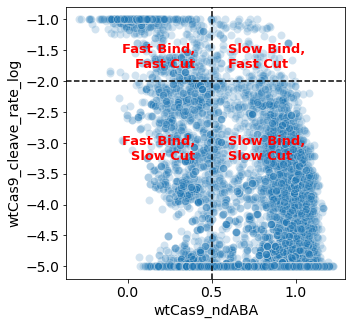

In [7]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax = sns.scatterplot(x='wtCas9_ndABA', y='wtCas9_cleave_rate_log', data=df1_pred, ax=ax, alpha=0.2)
ax.axvline(0.5, color='k', ls='--')
ax.axhline(-2, color='k', ls='--')
ss.pearsonr(df1_pred['wtCas9_ndABA'], df1_pred['wtCas9_cleave_rate_log'])

ax.text(0.4, -1.6, "Fast Bind,\nFast Cut", va='center', ha='right', fontsize=13, fontweight="bold", color="r")
ax.text(0.6, -1.6, "Slow Bind,\nFast Cut", va='center', ha='left', fontsize=13, fontweight="bold", color="r")
ax.text(0.4, -3.1, "Fast Bind,\nSlow Cut", va='center', ha='right', fontsize=13, fontweight="bold", color="r")
ax.text(0.6, -3.1, "Slow Bind,\nSlow Cut", va='center', ha='left', fontsize=13, fontweight="bold", color="r")


## Fig. 5BCDE
Rates for each class

In [8]:
def make_rate_plot(query, df1_pred, df2_pred):
    fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
    a = df1_pred.query(query).melt(
        id_vars="descriptor", 
        value_vars=['k_on', 'k_OI', 'k_IC', 'k_cat'])
    b = df2_pred.query(query).melt(
        id_vars="descriptor", 
        value_vars=['k_on', 'k_OI', 'k_IC', 'k_cat'])
    ax = sns.lineplot(x='variable', y='value', marker='o', data=a, ax=axs[0], ci='sd', label="gRNA1 model")
    sns.lineplot(x='variable', y='value', marker='o', data=b, ax=ax, ci='sd', label="gRNA2 model")
    ax.set_xlabel("Forward Rates")
    ax.set_ylabel("log(kT)")
    ax.axhline(0, ls="--", color='k')
    
    a = df1_pred.query(query).melt(
        id_vars="descriptor", 
        value_vars=['k_off', 'k_IO', 'k_CI'])
    b = df2_pred.query(query).melt(
        id_vars="descriptor", 
        value_vars=['k_off', 'k_IO', 'k_CI'])
    ax = sns.lineplot(x='variable', y='value', marker='o', data=a, ax=axs[1], ci='sd', label="gRNA1 model")
    sns.lineplot(x='variable', y='value', marker='o', data=b, ax=ax, ci='sd', label="gRNA2 model")
    ax.set_xlabel("Reverse Rates")
    ax.set_ylabel("log(kT)")
    ax.axhline(0, ls="--", color='k')
    ax.legend().remove()
    return fig, axs

Text(0.5, 0.98, 'Fast Bind, Fast Cut\n(n=776)')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


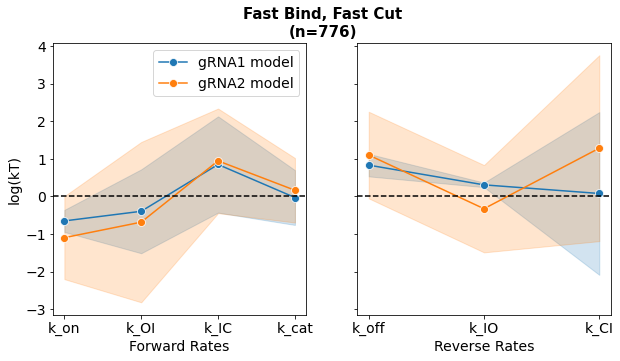

In [9]:
query = "wtCas9_ndABA<0.5 and wtCas9_cleave_rate_log > -2"
fig, axs = make_rate_plot(
    query=query, 
    df1_pred=df1_pred, df2_pred=df2_pred)
fig.suptitle(
    "Fast Bind, Fast Cut\n(n=%i)"%df1_pred.query(query).shape[0], 
    fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Fast Bind, Slow Cut\n(n=1985)')

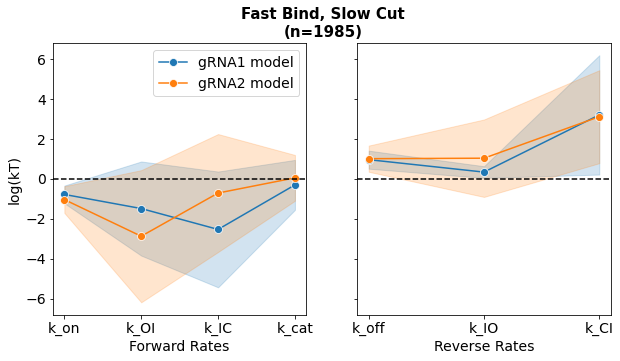

In [10]:
query = "wtCas9_ndABA<0.5 and wtCas9_cleave_rate_log < -2"
fig, axs = make_rate_plot(
    query=query, 
    df1_pred=df1_pred, df2_pred=df2_pred)
fig.suptitle(
    "Fast Bind, Slow Cut\n(n=%i)"%df1_pred.query(query).shape[0],
    fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Slow Bind, Fast Cut\n(n=139)')

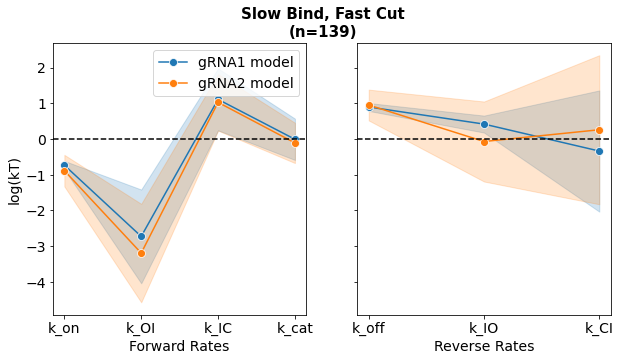

In [11]:
query = "wtCas9_ndABA>0.5 and wtCas9_cleave_rate_log > -2"
fig, axs = make_rate_plot(
    query=query, 
    df1_pred=df1_pred, df2_pred=df2_pred)
fig.suptitle(
    "Slow Bind, Fast Cut\n(n=%i)"%df1_pred.query(query).shape[0],
    fontsize=15, fontweight="bold", )

Text(0.5, 0.98, 'Slow Bind, Slow Cut\n(n=11093)')

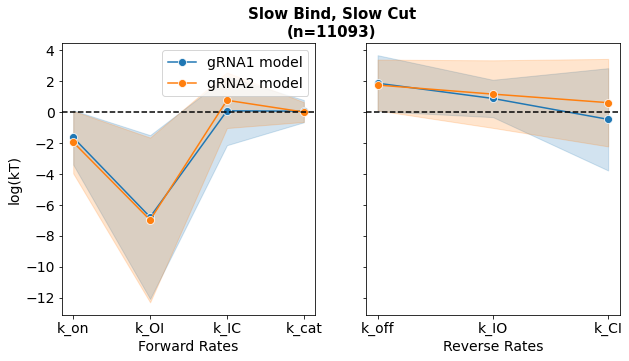

In [12]:
query = "wtCas9_ndABA>0.5 and wtCas9_cleave_rate_log < -2"
fig, axs = make_rate_plot(
    query=query, 
    df1_pred=df1_pred, df2_pred=df2_pred)
fig.suptitle(
    "Slow Bind, Slow Cut\n(n=%i)"%df1_pred.query(query).shape[0],
    fontsize=15, fontweight="bold")

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Sep 08 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

seaborn   : 0.11.1
matplotlib: 3.4.3
tensorflow: 1.15.0
src       : 0.0.1
amber     : 0.1.2-pmbga
pandas    : 1.3.5
scipy     : 1.7.3
numpy     : 1.21.6

Watermark: 2.3.1

